In [1]:
# 運行相同路徑資料夾裡的 py檔。此為私人設定，需開通群益的 API，並且完成電腦環境設置。詳情參考附錄
%run max_login.py
%matplotlib auto

VARIANT_TRUE, 0xFFFF SKReplyLib_OnReplyMessage:Announcement callback.
VARIANT_TRUE, 0xFFFF SKReplyLib_OnReplyMessage:Announcement callback.
Login, SK_WARNING_LOGIN_ALREADY
Initialize  SK_SUCCESS
GetUserAccount  SK_SUCCESS
ReadCertByID SK_SUCCESS
Using matplotlib backend: Qt5Agg
等待連線..., nkind=  3001
連線成功。 nkind=  3003


In [2]:
# ------------#
# 匯入所需模組 #
# ------------#
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', 150) 
pd.set_option('display.max_rows', 150)
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline
import seaborn as sns
import time   # , datetime
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']

# -------------------------------#
# 編寫讀取股票報價 &計算振幅的函式 #
# -------------------------------#

# 由券商(群益API)提供每檔股票的「日期、開、高、低、收、量」，資料頻率為「天」
def kline (ticker, days, period= 4):
    nCode = skQ.SKQuoteLib_RequestKLine( ticker, sKLineType = period, sOutType = 1)
    df = pd.DataFrame(EventQ.KlineData)[days:]
    df.columns = ['date','open','high','low','close','volume']
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(['date'])
    df = pd.DataFrame(df,dtype = np.float)
    return df

# 算振幅，此處以近 66個交易日(一個季)為例
def voladay (ticker):
    df= kline(ticker, -66)
    # 取近 22個交易日(一個月)為移動平均值
    return ((df['high']- df['low'])/ df['close'].shift(1)* 100).rolling(22).mean()

# 由券商(群益API)提供每檔股票的「日期、開、高、低、收、量」，資料頻率為「1分鐘」
def vola15m (ticker):
    # 只選近 10天 (2700分鐘)
    df= kline(ticker, -2700, 0)
    df_halfhr= pd.DataFrame()
    df_halfhr['high'] = df['high'].resample('15T', label = 'right', closed = 'right').max()
    df_halfhr['low'] = df['low'].resample('15T', label ='right', closed = 'right').min()
    df_halfhr['close'] = df['close'].resample('15T', label = 'right', closed = 'right').last()
    df_halfhr= df_halfhr.dropna()
    return ((df_halfhr['high']-df_halfhr['low'])/df_halfhr['close'].shift(1)).cumsum()

# ---------#
# 匯入csv檔 #
# ---------#

# 把有股票代號的 csv檔設成 dict結構。此處拿有發行"股票期貨"的股票為例
data = pd.read_csv('股期.csv')
futures = { i:str(j) for i,j in zip(list(data['公司名稱']), list(data['公司代號']))}

C:\Users\hhped\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


,祥碩,亞德客-KY,華新科,原相,璟德,玉晶光,精測,新日興,聯茂,聯亞,臻鼎-KY,全新,同欣電,欣興,智邦,台郡,國巨,友達,上銀,信昌電,華通,大江,碩禾,網家,台光電,億光
44,5.111585,4.558898,4.514291,4.352823,4.199963,4.170511,4.157801,4.139713,4.116698,4.091606,3.990349,3.984656,3.92636,3.792241,3.720988,3.71627,3.715164,3.690893,3.688171,3.682079,3.680594,3.67893,3.614473,3.556468,3.519124,3.508591


C:\Users\hhped\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


'跑了2分54秒'

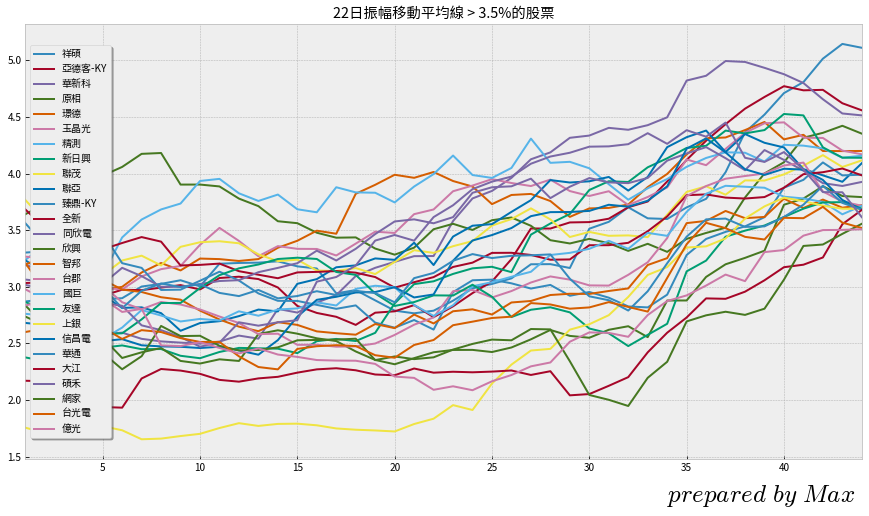

In [3]:
# ----------------#
# 日振幅 > 3.5%的 #
# ----------------#

# 計時起點
start = time.clock()

# 把 csv檔裡所有股號，經振幅經式運算後，排成一大張 DataFrame
vola_day = pd.DataFrame({ i : voladay(j) for i,j in futures.items()}).dropna()

# 把預設的日期索引，改成簡單的流水篇號
vola_day.index = range(1,len(vola_day) + 1)

# 把振幅降冪排序，只選出 >3.5%的
high_vola = vola_day.loc[len(vola_day):] [ vola_day.loc[len(vola_day):] > 3.5].sort_values(by= len(vola_day), ascending= False,axis= 1).dropna(axis=1)

# 檢視有哪些股票被篩選出來。    display類似 print指令，但display可呈現 DataFrame表格
display(high_vola)

# 畫主圖、上標題、以及各顏色折線圖所對應什麼股票的註解
vola_day[high_vola.keys()].plot(figsize=(15, 8), title='22日振幅移動平均線 > 3.5%的股票'); plt.legend(loc= 6, shadow=True)

# 加上標題以外的文字(非必需)
_= plt.text( 34 ,1.1, r'$prepared~by~Max$', fontsize=25)

# 計時終止，回報運算耗時多久
end = time.clock()
f'跑了{time.gmtime(end-start)[4]}分{time.gmtime(end-start)[5]}秒'

,威剛,中美晶,力成,神盾,環球晶,致茂,嘉聯益,力旺,群創,台虹,景碩,台燿,晶電,胡連,群聯,嘉澤,亞光,穩懋,和大,瑞昱,創意,旺宏,大同,華邦電,泰博
44,3.489404,3.488657,3.434137,3.427313,3.417346,3.361646,3.352726,3.328567,3.326317,3.325379,3.292126,3.255869,3.232754,3.221701,3.221659,3.214908,3.198772,3.195644,3.133354,3.118126,3.113804,3.081648,3.052977,3.035507,3.022008


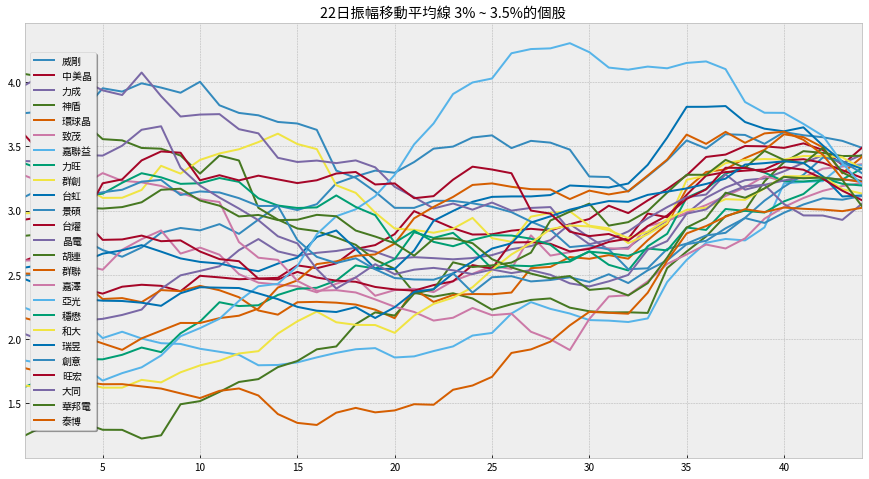

In [4]:
# ----------------#
# 日振幅 < 3.5%的 #
# ----------------#

# csv所有股票標的運算結果已存在 vola_day這個變數中，而把振幅高(high_vola)的刪去後，留下的即是低振幅的標的
low_vola = vola_day.loc[len(vola_day):].drop(columns = high_vola.columns, axis=1) 

# 降冪排序後覆蓋掉原有變數，並篩掉振幅太低的，避免資料過多、圖例太擠 (此處以 3%為門檻)
low_vola = low_vola[low_vola > 3].sort_values(by = len(vola_day), ascending= False,axis= 1).dropna(axis=1)

# 檢視剩哪些股票被篩選出來。
display(low_vola)

# 畫主圖、上標題、以及各顏色折線圖所對應什麼股票的註解
vola_day[low_vola.keys()].plot(figsize=(15, 8), title='22日振幅移動平均線 3% ~ 3.5%的個股'); plt.legend(loc= 6, shadow=True)

In [5]:
# -----------#
# 算 15m振幅 #
# -----------#

# 計時起點
start = time.clock()

# 把之前篩出高振幅 + 低振幅的股票，編成新的 dict資料結構
high_dict = { i : j for i,j in zip( list(high_vola.columns), [futures[i] for i in list(high_vola.columns)])}
low_dict = { i : j for i,j in zip( list(low_vola.columns), [futures[i] for i in list(low_vola.columns)])}
all_dict = high_dict.copy()
all_dict.update(low_dict)

# 套用 vola15m函式，將原先是以日為時間單位的選股方式，換成以15分鐘為時間單位，重新選一次
vola_15m = pd.DataFrame({ i : vola15m(j) for i,j in all_dict.items()})
vola_15m.index = range(1,len(vola_15m) + 1)
# 依最近一筆資料降冪排序，條件為近 10個交易日、也就是 180根 15分K棒，選出振幅累加達 150% (換算為每根15分K棒有 0.83%的振幅)
result = vola_15m.loc[len(vola_15m):] [vola_15m.loc[len(vola_15m):] > 1.5 ].sort_values(by= len(vola_15m), ascending= False,axis= 1).dropna(axis=1)  

# 檢視哪些股票被選出來
display(result)

# 計時結算，看耗時多久
end = time.clock()
f'跑了{time.gmtime(end-start)[4]}分{time.gmtime(end-start)[5]}秒' 

C:\Users\hhped\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


,祥碩,聯茂,原相,友達,臻鼎-KY,中美晶,台光電,全新,新日興
180,1.752238,1.723099,1.713501,1.71342,1.620838,1.619932,1.590299,1.524085,1.511564


C:\Users\hhped\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


'跑了1分57秒'

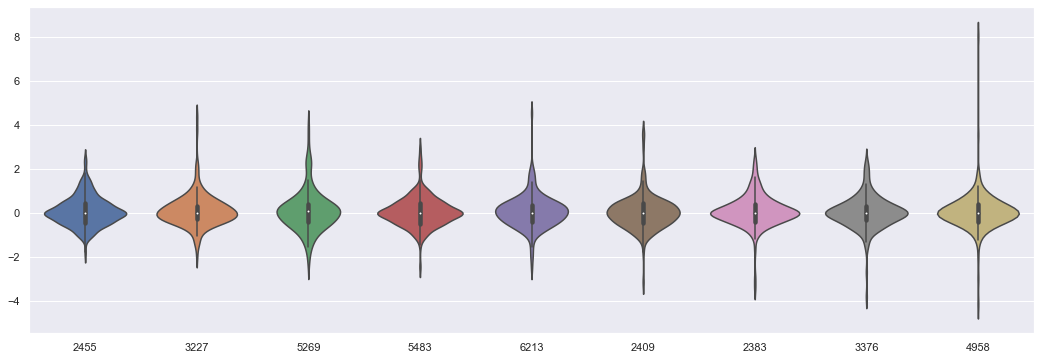

In [6]:
# ----------------------------#
# 列出將創新高 來評估追高的風險 #
# ----------------------------#

# 算每根 15分K的漲跌幅
def pct15m (ticker):
    df = kline(ticker, -2700, 0)
    df_halfhr = pd.DataFrame()
    df_halfhr['close'] = df['close'].resample('15T', label ='right', closed ='right').last()
    df_halfhr = df_halfhr.dropna() 
    return df_halfhr['close'].pct_change()*100

# 依之前選出的「股票名稱」，換成「股票代號」套入函式運算，畫成小提琴圖，依該股票15分K的漲跌幅平均值做降冪排序
output = pd.DataFrame({ j : pct15m(j) for j in ['5269','6213','3227','2409','4958','5483','2383','2455','3376']}).dropna()
output.index = range(1,len(output) + 1)
output.loc[len(output)+1] = output.min()
output = output.sort_values(by= len(output), ascending= False,axis= 1)

# 觀察漲跌幅的頻率分佈，目的是挑 15分K棒比較少出現急跌的股票，評估進場後遇上急跌的可能性、以及幅度
sns.set(rc={'figure.figsize':(18,6)})
sns.violinplot(data= output.drop([180]))